# Notebook de modelagem e avaliação 

## Importação das bibliotecas

In [10]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb


In [11]:
# Configurar paleta de cores e estilo

# Matplotlib
mpl.rcParams["figure.figsize"] = (20, 7)
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.titlesize"] = 25
mpl.rcParams["figure.dpi"] = 100

# Seaborn
sns.set_style('whitegrid', {"grid.color": ".8", "grid.linestyle": "--"})
sns.set_palette(palette='mako')

## Aquisição dos dados

In [12]:
input_path = '../data/processed/dados_historicos_ibovespa_2015-2025_processed.csv'

df = pd.read_csv(input_path, index_col='ds', parse_dates=['ds'])
df.tail()

,close,open,high,low,volume,daily_return,return_lag_1,return_lag_2,return_lag_3,return_lag_4,...,atr_14,obv,day_of_week,day_of_month,month,year,eua_return_lag1,china_return_lag1,europe_return_lag1,oil_return_lag1
ds,,,,,,,,,,,,,,,,,,,,,
2025-06-12,137800,137127,137931,136175,7.120000e+09,0.0049,0.0051,0.0054,-0.0030,-0.0010,...,1746.368879,1.365131e+11,3,12,6,2025,-0.002744,0.005170,-0.002228,0.043368
2025-06-13,137213,137800,137800,136586,8.630000e+09,-0.0043,0.0049,0.0051,0.0054,-0.0030,...,1708.342531,1.278831e+11,4,13,6,2025,0.003822,0.000101,-0.002472,-0.005876
2025-06-16,139256,137212,139988,137212,7.620000e+09,0.0149,-0.0043,0.0049,0.0051,0.0054,...,1784.603778,1.355031e+11,0,16,6,2025,-0.011296,-0.007542,-0.008685,0.070213
2025-06-17,138840,139256,139497,138293,8.380000e+09,-0.0030,0.0149,-0.0043,0.0049,0.0051,...,1743.132080,1.271231e+11,1,17,6,2025,0.009393,0.003474,0.006268,-0.013472
2025-06-18,138717,138844,139161,138443,8.320000e+09,-0.0009,-0.0030,0.0149,-0.0043,0.0049,...,1669.908360,1.188031e+11,2,18,6,2025,-0.008352,-0.000391,-0.007578,0.043971


## Pré-processamento dos dados

Primeiro, vamos criar a **variável alvo** com horizonte de 1 dia para que o modelo de classificação consiga prever se o fechamento de amanhã será maior que o de hoje.

* `1` para dias de **Alta**
* `0` para dias de **Baixa**

In [13]:
# criando uma coluna de direção (baixa = 0 ou alta = 1)
target_values = (df['close'].shift(-1) < df['close']).astype(int)
df.insert(0, 'target', target_values)

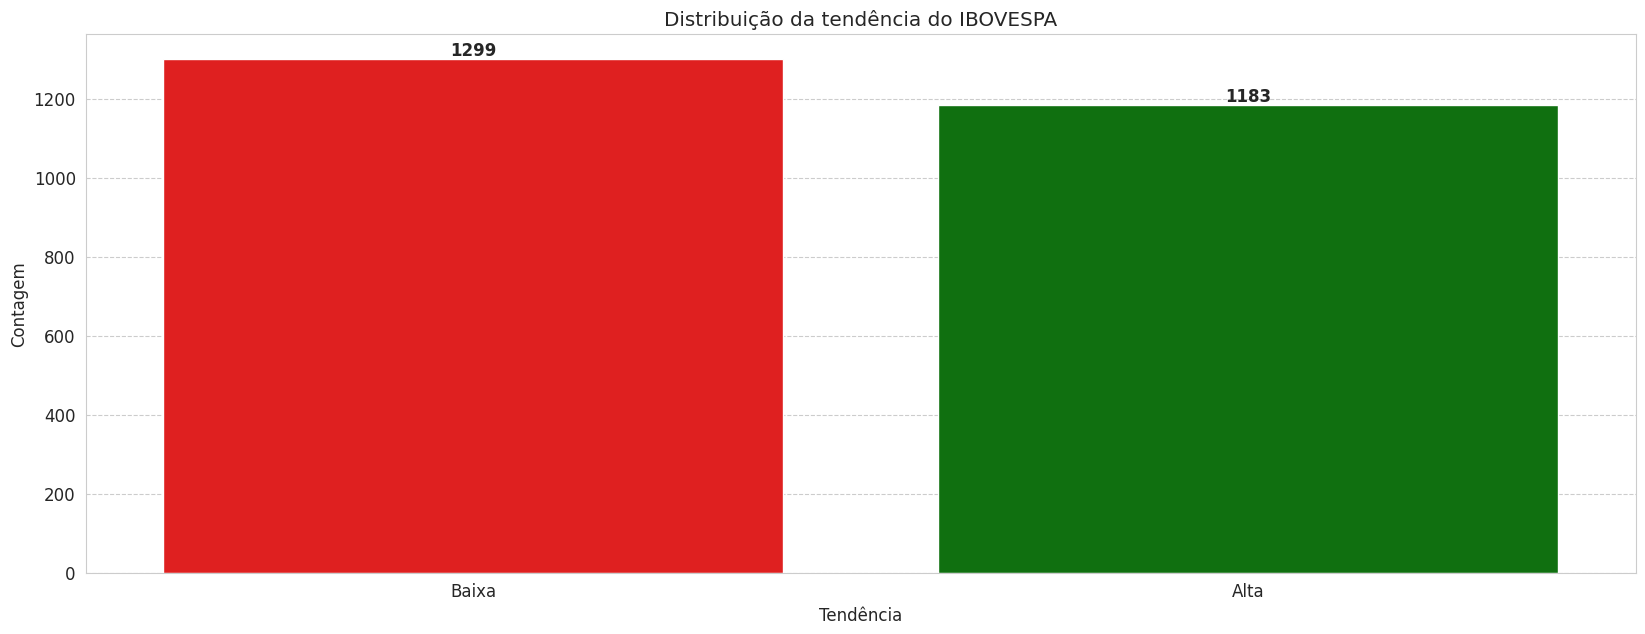

In [14]:
# Paleta
palette_green_red = {0: 'red', 1: 'green'}

# Gráfico de qtd de dias com tendência alta ou baixa
ax = sns.countplot(data=df, x='target', hue='target', palette=palette_green_red, legend=False)

# Título e rótulos dos eixos
plt.title('Distribuição da tendência do IBOVESPA')
plt.xlabel('Tendência')
plt.ylabel('Contagem')
plt.xticks(ticks=[0, 1], labels=['Baixa', 'Alta'])

# Adiciona os valores nas barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                  (p.get_x() + p.get_width() / 2, height),
                  ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

In [15]:
# Porcentagem da distribuição da tendência
df['target'].value_counts(normalize=True)

target
0    0.523368
1    0.476632
Name: proportion, dtype: float64

Após a análise da distribuição da variável alvo, verificamos que o dataset é naturalmente balanceado. Portanto, a aplicação de técnicas de reamostragem como *oversampling* ou *undersampling* não se faz necessária.

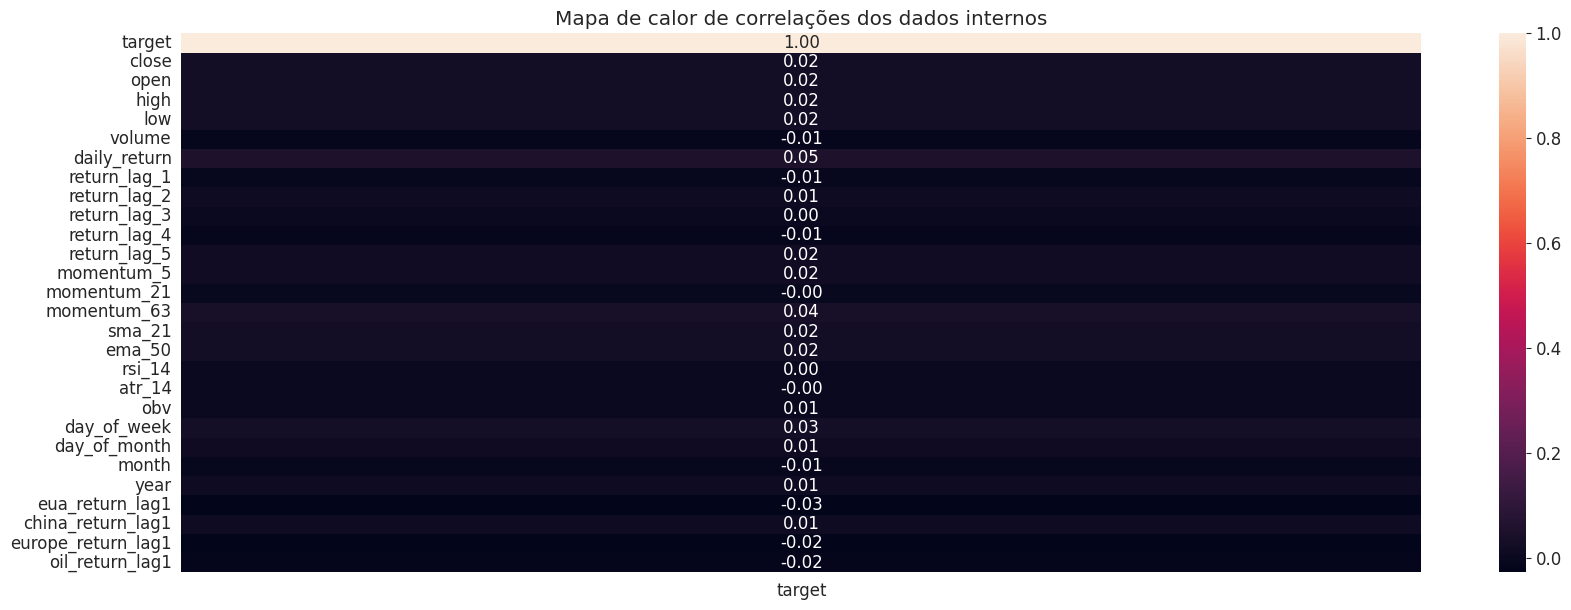

In [16]:
corr = df.corr(numeric_only=True)
target_corr = corr[['target']]


sns.heatmap(target_corr, annot=True, fmt='.2f')
plt.title('Mapa de calor de correlações dos dados internos')
plt.show()

Há uma correlação quase neutra entre a variável alvo e a maioria das variáveis.

## Construção do modelo de classificação

In [17]:
# definindo variáveis preditoras e variável alvo
remove_features = ['open', 'high', 'low', 'close', 'volume', 'target', 'ema_50', 'obv']

X = df.drop(columns=remove_features)
y = df['target']

In [18]:
# divisão entre treino e teste (30 dias de pregão, conforme requisito) de forma cronológica (sem aleatoriedade)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30, shuffle=False)

print(f"Tamanho do treino: {len(X_train)} amostras")
print(f"Tamanho do teste: {len(X_test)} amostras")

Tamanho do treino: 2452 amostras
Tamanho do teste: 30 amostras


Diferente dos demais modelos utilizados, a Regressão Logística (que será o modelo de baseline) e o SVM são sensíveis à escala das features. Por isso, vamos padronizar os dados para esses dois modelos. Como dados financeiros podem ter eventos extremos em épocas de crise, escolhemos o método de escalonamento do `StandardScaler()`, pois é mais robusto a outliers.

In [19]:
# definindo modelos de classificação
seed = 2934
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(random_state=seed, n_jobs=-1))
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(random_state=seed))
    ]),
    'Decision Tree': DecisionTreeClassifier(max_depth=20, random_state=seed),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=seed, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', random_state=seed, n_jobs=-1)
}

In [20]:
# treinando os modelos
for name, model in models.items():
    print(f"Treinando {name}...")
    model.fit(X_train, y_train)

print("Todos os modelos foram treinados!")

Treinando Logistic Regression...


/usr/lib64/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


Treinando SVM...
Treinando Decision Tree...
Treinando Random Forest...
Treinando XGBoost...
Todos os modelos foram treinados!


## Avaliação do modelo

In [21]:
# comparando o desempenho dos modelos
performance = pd.DataFrame(
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"]
)

for name, model in models.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    performance.loc[performance.shape[0]] = {
        "Model": name,
        "Accuracy": report["accuracy"],
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
    }
performance.set_index("Model", inplace=True)
performance = performance.map(lambda x: f"{100 * x:2.2f} %")
performance.sort_values("F1-Score", ascending=False, inplace=True)

performance

,Accuracy,Precision,Recall,F1-Score
Model,,,,
SVM,63.33 %,67.05 %,63.33 %,61.22 %
Decision Tree,56.67 %,56.94 %,56.67 %,56.23 %
XGBoost,56.67 %,57.50 %,56.67 %,55.43 %
Random Forest,56.67 %,58.52 %,56.67 %,54.17 %
Logistic Regression,53.33 %,53.97 %,53.33 %,51.39 %


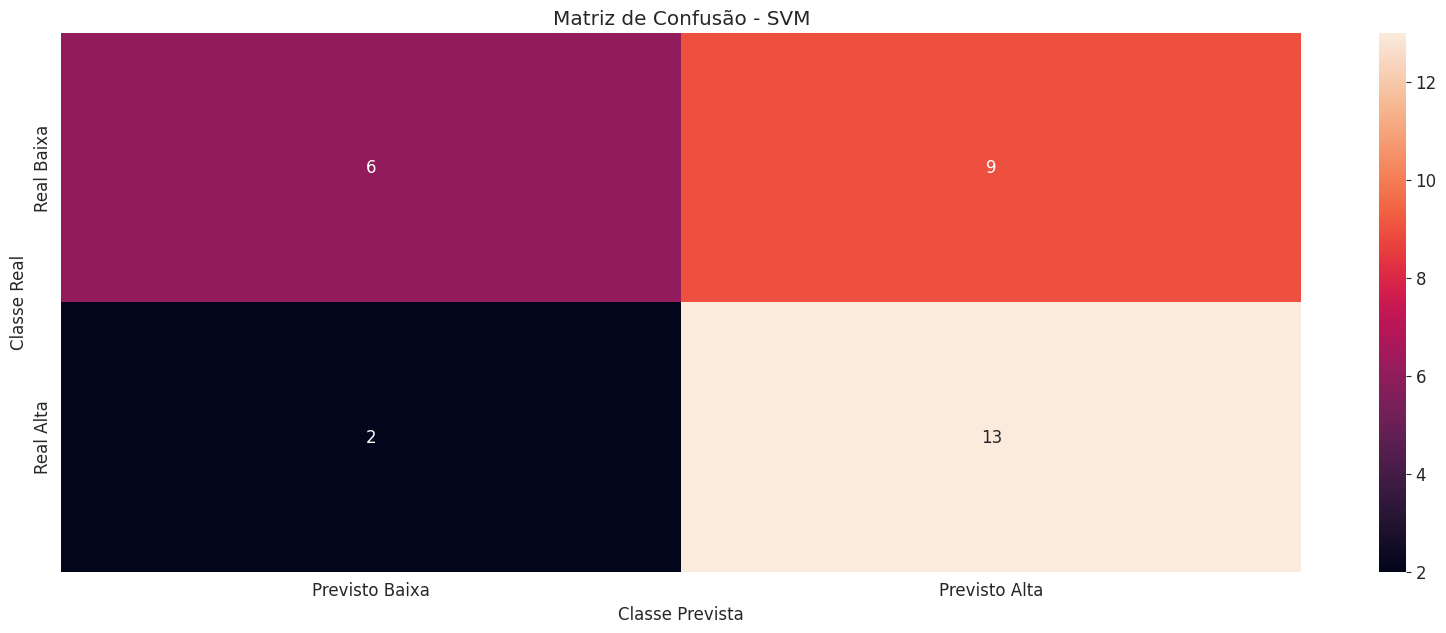

In [22]:
# matriz de confusão para o melhor modelo
best_model_name = performance.idxmax().iloc[0]
best_model = models[best_model_name]
cm = confusion_matrix(y_test, best_model.predict(X_test))

sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=['Previsto Baixa', 'Previsto Alta'], 
            yticklabels=['Real Baixa', 'Real Alta'])
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

O modelo acerta muito bem a classe "Alta", mas tem dificuldade de prever a classe "Baixa".

## Seleção das features

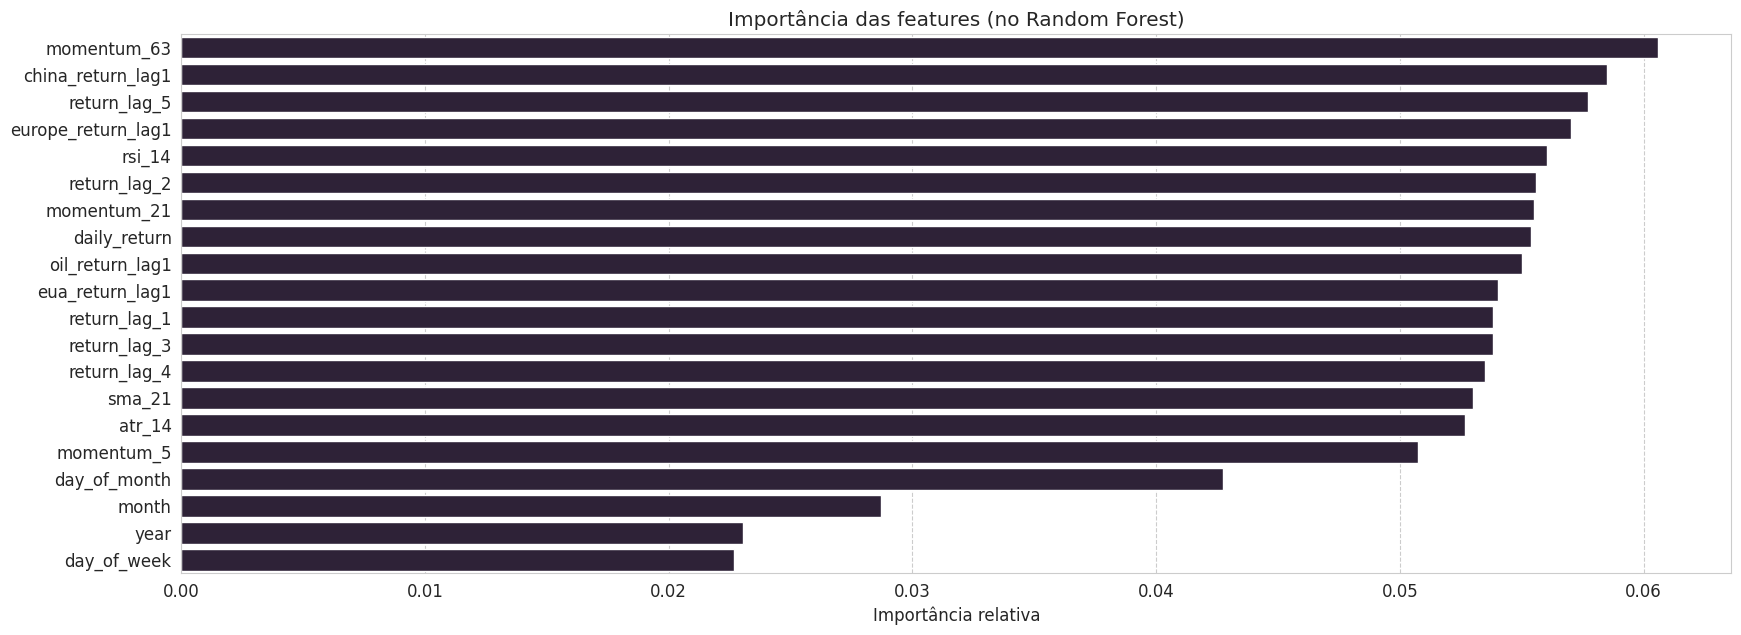

In [23]:
feature_importances = pd.Series(models['Random Forest'].feature_importances_, index=X_train.columns).sort_values(ascending=False).reset_index(name='importancia')

# plotando as features em ordem de importância para a previsão do modelo
sns.barplot(data=feature_importances, x='importancia', y='index')
plt.title('Importância das features (no Random Forest)')
plt.ylabel('')
plt.xlabel('Importância relativa')
plt.show()

In [24]:
# filtrar as features que atendem ao critério
importance_threshold = 0.045
best_features = feature_importances[feature_importances['importancia'] > importance_threshold]['index'].tolist()

print(f"Número de features original: {len(feature_importances)}")
print(f"Número de features após seleção com limiar de {importance_threshold}: {len(best_features)}")
print("\nFeatures que serão mantidas para a otimização:")
print(list(best_features))

Número de features original: 20
Número de features após seleção com limiar de 0.045: 16

Features que serão mantidas para a otimização:
['momentum_63', 'china_return_lag1', 'return_lag_5', 'europe_return_lag1', 'rsi_14', 'return_lag_2', 'momentum_21', 'daily_return', 'oil_return_lag1', 'eua_return_lag1', 'return_lag_1', 'return_lag_3', 'return_lag_4', 'sma_21', 'atr_14', 'momentum_5']


In [25]:
# dividir treino e testar novamente com as novas features
X_train_selected = X_train[best_features]
X_test_selected = X_test[best_features]

## Ajuste de hiperparâmetros com validação cruzada

A validação cruzada ajuda a garantir que o modelo não está sobreajustado aos dados de treinamento e terá um bom desempenho em dados novos. 

In [26]:
# hiperparâmetros que iremos testar
# usamos 'model__parametro' por causa do pipeline
param_grid_svm = {
    'model__C': [0.1, 1, 10, 100],
    'model__gamma': ['scale', 'auto', 0.1, 1],
    'model__kernel': ['rbf']
}

# validação cruzada para dados de séries temporais
tscv = TimeSeriesSplit(n_splits=5)

# configuração do GridSearchCV
grid_search_svm = GridSearchCV(
    estimator=models['SVM'],
    param_grid=param_grid_svm,
    scoring='accuracy',
    cv=tscv,
    n_jobs=-1
)

grid_search_svm.fit(X_train_selected, y_train)

# análise dos resultados
print("Melhores parâmetros para o SVM: ", grid_search_svm.best_params_)
print("Melhor acurácia na validação cruzada do SVM: {:.2%}".format(grid_search_svm.best_score_))

/usr/lib64/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib64/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib64/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/li

Melhores parâmetros para o SVM:  {'model__C': 1, 'model__gamma': 1, 'model__kernel': 'rbf'}
Melhor acurácia na validação cruzada do SVM: 53.04%


In [27]:
# melhor SVM no conjunto de teste
best_svm = grid_search_svm.best_estimator_
pred_test_svm = best_svm.predict(X_test_selected)

print("Relatório de classificação do SVM:\n")
print(classification_report(y_test, pred_test_svm))

Relatório de classificação do SVM:

              precision    recall  f1-score   support

           0       0.54      0.47      0.50        15
           1       0.53      0.60      0.56        15

    accuracy                           0.53        30
   macro avg       0.53      0.53      0.53        30
weighted avg       0.53      0.53      0.53        30



In [28]:
# hiperparâmetros que iremos testar
param_grid_rf = {
    'n_estimators': [100, 200],          # Número de árvores
    'max_depth': [10, 20, None],         # Profundidade máxima de cada árvore
    'min_samples_leaf': [1, 5, 10],      # Número mínimo de amostras em uma folha
    'max_features': ['sqrt', 'log2']     # Número de features a considerar em cada split
}

# validação cruzada para dados de séries temporais
tscv = TimeSeriesSplit(n_splits=5)

# configuração do GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=models['Random Forest'],
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=tscv,
    n_jobs=-1
)

grid_search_rf.fit(X_train_selected, y_train)

# análise dos resultados
print("Melhores parâmetros para o Random Forest: ", grid_search_rf.best_params_)
print("Melhor acurácia na validação cruzada do Random Forest: {:.2%}".format(grid_search_rf.best_score_))

Melhores parâmetros para o Random Forest:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 100}
Melhor acurácia na validação cruzada do Random Forest: 53.82%


In [29]:
# melhor Random Forest no conjunto de teste
best_rf = grid_search_rf.best_estimator_
pred_test_rf = best_rf.predict(X_test_selected)

print("Relatório de classificação do Random Forest:\n")
print(classification_report(y_test, pred_test_rf))

Relatório de classificação do Random Forest:

              precision    recall  f1-score   support

           0       0.55      0.40      0.46        15
           1       0.53      0.67      0.59        15

    accuracy                           0.53        30
   macro avg       0.54      0.53      0.52        30
weighted avg       0.54      0.53      0.52        30



## Exportação do modelo

In [30]:
# import joblib

# # salvar o melhor modelo
# model_filename = f"models/{best_model_name.replace(' ', '_')}.joblib"
# joblib.dump(best_model, model_filename)

In [31]:
# import json

# # salvar as métricas de performance
# report_dict = classification_report(y_test, y_pred, output_dict=True)
# metrics_filename = f"reports/metrics_{best_model_name.replace(' ', '_')}.json"

# with open(metrics_filename, 'w', encoding='utf-8') as f:
#     json.dump(report_dict, f, ensure_ascii=False, indent=4)